# Finding the best "hygge" path
This notebook explores the different ways of finding the shortest path while ensuring that the path is "hyggelig"

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from collections import Counter

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Load base street paths

In [45]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


## Load bird path features
This code is an excerpt from `birds.ipynb`

In [46]:
birds = pd.read_csv('../data/birds.csv')
birds = birds.drop(columns='Unnamed: 0')

gdf = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(birds.obs_laengdegrad, birds.obs_breddegrad), crs="EPSG:4326"
)

# project to EPSG:25832
gdf = gdf.to_crs('EPSG:25832')

In [47]:
# remove observations outside of Copenhagen

# load shape of Copenhagen
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
cph = ox.geocode_to_gdf(geocodes)
cph = cph.to_crs('EPSG:25832')
cph_poly = cph.dissolve().geometry.iloc[0]

# find intersecting bird observations
gdf['intersection_geometry'] = gdf.geometry.intersection(cph_poly)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [48]:
# remove observations without exact coordinates
gdf = gdf[~gdf.intersection_geometry.is_empty]

In [49]:
# create a buffer around each observation
buffer_radius = 50  # radius (in meters due to EPSG:25832)
gdf['buffer'] = gdf.buffer(buffer_radius)
gdf_buffer = gdf.set_geometry('buffer')

In [50]:
intersections = edges.sjoin(gdf_buffer)
intersections = gpd.GeoDataFrame(intersections, geometry=intersections.geometry_left, crs=gdf.crs)

In [51]:
bird_counts = intersections.groupby(['u', 'v', 'key']).size()
bird_counts.name = 'bird_counts'

In [52]:
edges = edges.merge(bird_counts, left_index=True, right_index=True, how='left')

In [53]:
edges['bird_counts'] = edges.bird_counts.fillna(0)

In [ ]:
G = ox.graph_from_gdfs(nodes, edges)

In [35]:
list(G.nodes)[100]

1578270263

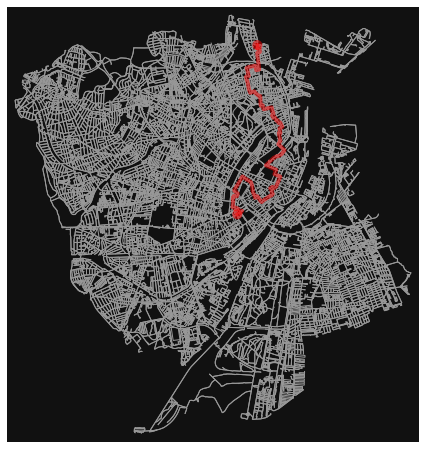

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [60]:
orig = 118725
dest = 1578270263
route = ox.shortest_path(G, orig, dest, weight='bird_counts')
ox.plot_graph_route(G, route, node_alpha=0)